In [99]:
import pandas as pd
import numpy as np

empl_survey = pd.read_csv('empl_survey.csv')
empl_survey['name'] = empl_survey['name'].replace('Per√∫', 'Peru')

In [100]:
def create_filtered_df(prompt):
    _df = empl_survey[empl_survey['Translated_text_question'].isin(prompt)]
    _df['new_id'] = _df['user_id'].astype(str) + '_' + _df['name'].astype(str) + '_' + _df['id_record'].astype(str)
    df_limited = _df[['new_id','Translated_text_question','Translated_text_option']]

    pivot_df = df_limited.pivot_table(index='new_id',
                            columns='Translated_text_question',
                            values='Translated_text_option',
                            aggfunc=lambda x: ' '.join(x)).reset_index()

    pivot_df[['org_id', 'country', 'empl_id']] = pivot_df['new_id'].str.split('_', expand=True)
    pivot_df.drop('new_id', axis=1, inplace=True)
    return pivot_df

In [101]:
reason_to_not_report = ['Please tell us why you decided not to file a complaint or report it.']
pivot_df_reason_to_not_report = create_filtered_df(reason_to_not_report)

/var/folders/xz/jfdt1g6s2cl606vc936ty97m0000gn/T/ipykernel_37973/2009669890.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['new_id'] = _df['user_id'].astype(str) + '_' + _df['name'].astype(str) + '_' + _df['id_record'].astype(str)


In [102]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.util import ngrams
from collections import Counter

from gensim import corpora
from gensim.models import LdaModel
import string


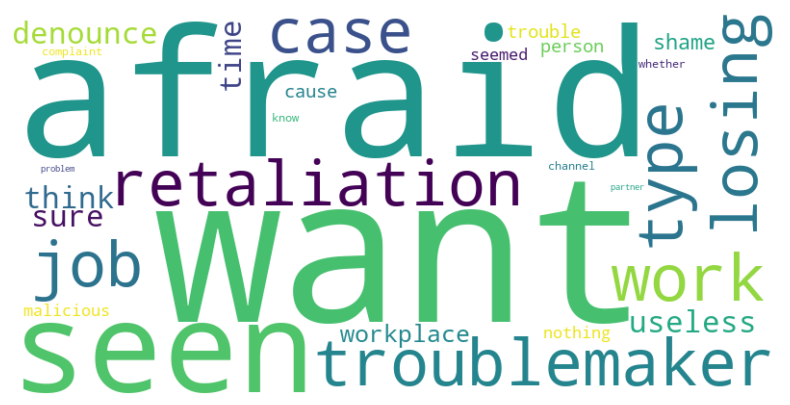

In [103]:

responses = pivot_df_reason_to_not_report['Please tell us why you decided not to file a complaint or report it.']

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
additional_words = ['sexual', 'harassment']
processed_responses = []
for response in responses:
    tokens = word_tokenize(response.lower())
    filtered_tokens = [lemmatizer.lemmatize(w) for w in tokens if w.isalpha() and w not in stop_words and
                      w not in additional_words]
    processed_responses.append(" ".join(filtered_tokens))

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(processed_responses)
word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq.sum())
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [104]:
stop_words = set(stopwords.words('english'))
translator = str.maketrans('', '', string.punctuation)

texts = [
    [word.lower() for word in word_tokenize(doc.translate(translator)) if word.isalpha() and word.lower() not in stop_words]
    for doc in responses
]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, passes=10)
for topic_num, words in lda_model.print_topics():
    print(f"Topic #{topic_num}: {words}")

Topic #0: 0.177*"malicious" + 0.177*"seemed" + 0.177*"nothing" + 0.081*"harassment" + 0.044*"sure" + 0.043*"workplace" + 0.043*"sexual" + 0.043*"time" + 0.043*"case" + 0.008*"didnt"
Topic #1: 0.110*"work" + 0.110*"seen" + 0.110*"troublemaker" + 0.110*"want" + 0.110*"didnt" + 0.062*"complaint" + 0.062*"whether" + 0.062*"cases" + 0.062*"know" + 0.062*"channel"
Topic #2: 0.181*"useless" + 0.181*"think" + 0.181*"denounce" + 0.053*"harassment" + 0.034*"afraid" + 0.034*"type" + 0.034*"losing" + 0.034*"job" + 0.034*"retaliation" + 0.028*"sure"
Topic #3: 0.103*"afraid" + 0.091*"type" + 0.091*"retaliation" + 0.091*"losing" + 0.091*"job" + 0.068*"didnt" + 0.068*"want" + 0.065*"troublemaker" + 0.065*"seen" + 0.065*"work"
Topic #4: 0.111*"harassment" + 0.074*"want" + 0.074*"didnt" + 0.057*"case" + 0.057*"time" + 0.057*"sexual" + 0.057*"workplace" + 0.057*"sure" + 0.043*"shame" + 0.039*"cause"
